In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.layers.python.layers import initializers
from tensorflow.examples.tutorials.mnist import input_data
from math import sqrt
import numpy as np
from sklearn.manifold import TSNE
get_ipython().magic('matplotlib inline')
get_ipython().magic('pylab inline')

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(mnist.test.labels)

[7 2 1 ... 4 5 6]


In [4]:
from keras.utils import np_utils# fix random seed for reproducibility
y_test = np_utils.to_categorical(mnist.test.labels)
print(y_test)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Using TensorFlow backend.


In [5]:
learning_rate = 0.00001
training_epochs = 15
batch_size = 100
display_step = 1
logs_path = './tensorflow_logs/mnist_metrics'
# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 28*28 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
margin = 1.0

In [7]:
    x_left = tf.placeholder(tf.float32, shape=[None, n_input], name='InputDataLeft')
    x_right = tf.placeholder(tf.float32, shape=[None, n_input], name='InputDataRight')
    label = tf.placeholder(tf.float32, shape=[None, 1], name='LabelData') # 0 if the same, 1 is different

    x_image_left = x_left
    x_image_right = x_right

In [20]:
  # def NN(inputs):

In [8]:
def tfNN(x, weights, biases):
    x = tf.scalar_mul(1.0/256.0, x)
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    out_layer = tf.add(tf.matmul(layer_3, weights['w4']), biases['b4'])
    return out_layer

In [9]:
    # Store layers weight & bias
    #tf.random_uniform(
    #shape,
    #minval=0,
    #maxval=None,
    #dtype=tf.float32,
    #seed=None,
    #name=None
    #)
    weights = {
    'w1': tf.Variable(tf.random_uniform([n_input, n_hidden_1], minval=-4*np.sqrt(6.0/(n_input + n_hidden_1)), maxval=4*np.sqrt(6.0/(n_input + n_hidden_1))), name='W1'),
    'w2': tf.Variable(tf.random_uniform([n_hidden_1, n_hidden_2], minval=-4*np.sqrt(6.0/(n_hidden_1 + n_hidden_2)), maxval=4*np.sqrt(6.0/(n_hidden_1 + n_hidden_2))), name='W2'),
    'w3': tf.Variable(tf.random_uniform([n_hidden_2, n_classes], minval=-4*np.sqrt(6.0/(n_hidden_2 + n_classes)), maxval=4*np.sqrt(6.0/(n_hidden_2 + n_classes))), name='W3'),
    'w4': tf.Variable(tf.random_uniform([n_classes, n_classes], minval=-4*np.sqrt(6.0/(n_classes + 2)), maxval=4*np.sqrt(6.0/(n_classes + 2))), name='W4')
    }
    biases = {
    'b1': tf.Variable(tf.truncated_normal([n_hidden_1]) / sqrt(n_hidden_1), name='b1'),
    'b2': tf.Variable(tf.truncated_normal([n_hidden_2]) / sqrt(n_hidden_2), name='b2'),
    'b3': tf.Variable(tf.truncated_normal([n_classes]) / sqrt(n_classes), name='b3'),
    'b4': tf.Variable(tf.truncated_normal([n_classes]) / sqrt(n_classes), name='b4')
    }

In [10]:
with tf.name_scope('Model'):
    # Model
    pred_left = tfNN(x_image_left, weights, biases)
    pred_right = tfNN(x_image_right, weights, biases)
    with tf.name_scope('Loss'):
        d = tf.reduce_sum(tf.square(tf.subtract(pred_left, pred_right)), 1, keep_dims=True)
    d_sqrt = tf.sqrt(d)
    loss = label * tf.square(tf.maximum(0.0, margin - d_sqrt)) + (1 - label) * d
    loss = 0.5 * tf.reduce_mean(loss)

    with tf.name_scope('AdamOptimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [11]:
    # Initializing the variables
    init = tf.global_variables_initializer()
    # Create a summary to monitor cost tensor
    tf.summary.scalar("loss", loss)

    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()

In [12]:

    # Launch the graph
sess = tf.Session()
sess.run(init)
    # op to write logs to Tensorboard
#summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

    # Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.0
    total_batch = int(mnist.train.num_examples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        left_batch_xs, left_batch_ys = mnist.train.next_batch(batch_size)
        right_batch_xs, right_batch_ys = mnist.train.next_batch(batch_size)
        labels = np.zeros((batch_size, 1))
        for l in range(batch_size):
            if left_batch_ys[l] == right_batch_ys[l]:
                labels[l, 0] = 0.0
            else:
                labels[l, 0] = 1.0
        _, l, summary = sess.run([optimizer, loss, merged_summary_op],
                                 feed_dict = {
                                              x_left: left_batch_xs, 
                                              x_right: right_batch_xs,
                                              label: labels,
                                             })
        # Write logs at every iteration
        #summary_writer.add_summary(summary, epoch * total_batch + i)
        # Compute average loss
        avg_loss += l / total_batch
    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        print ("Epoch:", '%04d' % (epoch+1), "loss =", "{:.9f}".format(avg_loss))

   # print ("Optimization Finished!")

    #print ("Run the command line:\n"       "--> tensorboard --logdir=./tensorflow_logs "       "\nThen open http://0.0.0.0:6006/ into your web browser")


Epoch: 0001 loss = 0.064200653
Epoch: 0002 loss = 0.056520799
Epoch: 0003 loss = 0.051354025
Epoch: 0004 loss = 0.048397793
Epoch: 0005 loss = 0.046401696
Epoch: 0006 loss = 0.044863890
Epoch: 0007 loss = 0.042009174
Epoch: 0008 loss = 0.041419002
Epoch: 0009 loss = 0.040068994
Epoch: 0010 loss = 0.038715607
Epoch: 0011 loss = 0.037500448
Epoch: 0012 loss = 0.038650912
Epoch: 0013 loss = 0.036761576
Epoch: 0014 loss = 0.036632265
Epoch: 0015 loss = 0.035978339


In [26]:
print(left_batch_xs)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
    # Test model
    # Calculate accuracy
    test_xs, test_ys = mnist.train.next_batch(5000)
    ans = sess.run([pred_left], feed_dict = { x_left: test_xs})

In [14]:
ans = ans[0]
print(ans)
print(len(ans))
print(test_ys)

[[-0.8381114   1.5780729  -5.345134   ... -4.421591   -2.2878385
   5.9426293 ]
 [-0.36738443  1.329838   -5.9633474  ... -4.7710605  -2.1976
   5.7436905 ]
 [-0.5971389   1.3976626  -5.178005   ... -4.494561   -2.1893253
   5.855554  ]
 ...
 [-0.678532    1.5239226  -6.085644   ... -4.696464   -2.5387137
   6.013779  ]
 [-0.83715725  1.3510245  -5.612461   ... -4.329441   -2.1274076
   5.6156793 ]
 [-0.2918554   1.6776863  -5.1012573  ... -4.5307336  -2.5024292
   5.966328  ]]
5000
[0 3 0 ... 2 6 0]


In [15]:
print(mnist.train.num_examples)

55000


In [16]:
    # Test model
    # Calculate accuracy
    test_xs, test_ys = mnist.train.next_batch(5000)
    ans = sess.run([pred_left], feed_dict = { x_left: test_xs})
    print(test_xs)
    print(test_ys[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
7


In [31]:
print(len(test_ys))

5000


In [17]:
print(ans[0])

[[-0.5025579   1.2206059  -5.509441   ... -4.2842298  -2.399009
   5.7110767 ]
 [-0.59680027  1.4676498  -5.4196453  ... -4.032259   -2.2151098
   5.8430624 ]
 [-0.5401863   1.3085862  -5.9583898  ... -4.869337   -2.2229967
   5.722969  ]
 ...
 [-0.60106736  1.6431131  -6.0293403  ... -4.65068    -2.279252
   5.9227953 ]
 [-0.46306723  1.3849088  -5.3485694  ... -4.108453   -2.1779695
   5.9388523 ]
 [-0.9671508   1.3879946  -5.4602695  ... -4.5797334  -2.162062
   5.621673  ]]


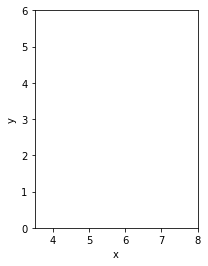

In [18]:
import matplotlib.pyplot as pyplot

%matplotlib inline

def plot_data(features,labels,axis,alpha=1.0):
    # separate features according to their class
    X0,X1,X2,X3,X4,X5,X6,X7,X8,X9 = features[labels==0], features[labels==1], features[labels==2], features[labels==3], features[labels==4], features[labels==5], features[labels==6], features[labels==7], features[labels==8], features[labels==9]
    
    # class 0 data
    axis.plot(X0[:,0], X0[:,1], 'o', color='green', markersize=1, alpha=alpha)
    # class 1 data
    axis.plot(X1[:,0], X1[:,1], 'o', color='red', markersize=1, alpha=alpha)
    # class 2 data
    axis.plot(X2[:,0], X2[:,1], 'o', color='blue', markersize=1, alpha=alpha)
    
    axis.plot(X3[:,0], X3[:,1], 'o', color='yellow', markersize=1, alpha=alpha)
    
    axis.plot(X4[:,0], X4[:,1], 'o', color='brown', markersize=1, alpha=alpha)
    
    axis.plot(X5[:,0], X5[:,1], 'o', color='black', markersize=1, alpha=alpha)
    
    axis.plot(X6[:,0], X6[:,1], 'o', color='pink', markersize=1, alpha=alpha)
    
    axis.plot(X7[:,0], X7[:,1], 'o', color='orange', markersize=1, alpha=alpha)
    
    axis.plot(X8[:,0], X8[:,1], 'o', color='cyan', markersize=1, alpha=alpha)
    
    axis.plot(X9[:,0], X9[:,1], 'o', color='gray', markersize=1, alpha=alpha)
    
    # set axes limits
    axis.set_xlim(3.5,8)
    axis.set_ylim(0,6)
    axis.set_aspect('equal')
    
    axis.set_xlabel('x')
    axis.set_ylabel('y')

figure,axis = pyplot.subplots(1,1)
plot_data(ans[0],test_ys,axis)
pyplot.show()

In [34]:
print(weights['w1'][0][0])

Tensor("strided_slice_1:0", shape=(), dtype=float32)


In [61]:
# Python optimisation variables
import tensorflow as tf
learning_rate = 0.01
epochs = 30
batch_size = 100

# declare the training data placeholders
# input x - for 28 x 28 pixels = 784
x = tf.placeholder(tf.float32, [None, 10])
# now declare the output data placeholder - 10 digits
y = tf.placeholder(tf.float32, [None, 10])

In [62]:
# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([10, 300], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([300]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([300, 10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')

In [63]:
# calculate the output of the hidden layer
hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.relu(hidden_out)

In [64]:
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out, W2), b2))

In [65]:
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                         + (1 - y) * tf.log(1 - y_clipped), axis=1))

In [66]:
# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)


In [67]:
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [68]:

    # Launch the graph
#sess = tf.Session()

    # op to write logs to Tensorboard
#summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

    # Training cycle
with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(30):
        avg_cost=0
        total_batch = int(mnist.train.num_examples / batch_size)
    # Loop over all batches
        for i in range(total_batch):
            left_batch_xs, left_batch_ys = mnist.train.next_batch(batch_size)
            ans = sess.run([pred_left], feed_dict = { x_left: left_batch_xs})
            ans=ans[0]
            left_batch_ys=np_utils.to_categorical(left_batch_ys)
        #right_batch_xs, right_batch_ys = mnist.train.next_batch(batch_size)
        #labels = np.zeros((batch_size, 1))
            _, c = sess.run([optimiser, cross_entropy], feed_dict={x: ans, y: left_batch_ys})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost)) 
    test_xs, test_ys = mnist.train.next_batch(5000)
    #test_ys=np_utils.to_categorical(test_ys)
    #print(sess.run(accuracy, feed_dict={x_left: test_xs, y: test_ys}))
    #test_xs, test_ys = mnist.train.next_batch(5000)
    #ans = sess.run([pred_left], feed_dict = { x_left: test_xs})
  

Epoch: 1 cost = 3.243
Epoch: 2 cost = 3.197
Epoch: 3 cost = 3.121
Epoch: 4 cost = 3.003
Epoch: 5 cost = 2.871
Epoch: 6 cost = 2.762
Epoch: 7 cost = 2.683
Epoch: 8 cost = 2.623
Epoch: 9 cost = 2.591
Epoch: 10 cost = 2.535
Epoch: 11 cost = 2.518
Epoch: 12 cost = 2.484
Epoch: 13 cost = 2.463
Epoch: 14 cost = 2.430
Epoch: 15 cost = 2.416
Epoch: 16 cost = 2.388
Epoch: 17 cost = 2.380
Epoch: 18 cost = 2.353
Epoch: 19 cost = 2.340
Epoch: 20 cost = 2.325
Epoch: 21 cost = 2.310
Epoch: 22 cost = 2.286
Epoch: 23 cost = 2.277
Epoch: 24 cost = 2.265
Epoch: 25 cost = 2.246
Epoch: 26 cost = 2.239
Epoch: 27 cost = 2.225
Epoch: 28 cost = 2.204
Epoch: 29 cost = 2.207
Epoch: 30 cost = 2.182


In [43]:
print(test_ys)

[1 2 2 ... 1 5 5]


In [44]:
print(weights['w1'])
print(W1)

<tf.Variable 'W1_1:0' shape=(784, 256) dtype=float32_ref>
<tf.Variable 'W1_2:0' shape=(2, 300) dtype=float32_ref>
